## Introduction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1hYHb0FTdKQCXZs3qCwVZnSuVGrZU2Z1w?usp=sharing)

It was in January of 2021 that **OpenAI** announced two new models: **DALL-E** and **CLIP**, both **multi-modality** models connecting **texts and images** in some way. In this article we are going to implement CLIP model from scratch in **PyTorch**. OpenAI has open-sourced some of the code relating to CLIP model but I found it intimidating and it was far from something short and simple. I also came across a good tutorial inspired by CLIP model on Keras code examples and I translated some parts of it into PyTorch to build this tutorial totally with our beloved PyTorch!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1hYHb0FTdKQCXZs3qCwVZnSuVGrZU2Z1w?usp=sharing)

### What does CLIP do? Why is it fun?

In [Learning Transferable Visual Models From Natural Language Supervision paper](https://arxiv.org/abs/2103.00020), OpenAI introduces their new model which is called **CLIP**, for **Contrastive Language-Image Pre-training**. In a nutshell, this model learns the relationship between a whole sentence and the image it describes; in a sense that when the model is trained, given an input sentence it will be able to retrieve the most related images corresponding to that sentence. The important thing here is that it is trained on full sentences instead of single classes like car, dog, etc. The intuition is that when trained on whole sentences, the model can learn a lot more things and finds some pattern between images and texts.
They also show that when this model is trained on a huge dataset of images and their corresponding texts, it can also act as a classifier too. I encourage you to study the paper to learn more about this exciting model and their astonishing results on benchmarking datasets . To mention just one, CLIP model trained with this strategy classifies ImageNet better than those SOTA models trained on the ImageNet itself optimized for the only task of classification!

As a **teaser** (!), let's see what the final model that we will build in this article from scratch is capable of: given a query (raw text) like "a boy jumping with skateboard" or "a girl jumping from swing", the model will retrieve the most relevant images:

![title_img](./images/teaser.png)

Let's see some more outputs:

![](./images/dogs.png)

In [2]:
!pip install timm
!pip install transformers

     |████████████████████████████████| 348kB 36.5MB/s 
     |████████████████████████████████| 2.5MB 29.7MB/s 
     |████████████████████████████████| 901kB 50.1MB/s 
     |████████████████████████████████| 3.3MB 47.4MB/s 


In [3]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

from datetime import datetime
import importlib
import results_generator
importlib.reload(results_generator)
from results_generator import *

In [4]:
# This code is only needed if the dataset is stored in google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# This code is only needed if the dataset is stored in google drive and it is 7z compressed
!p7zip -d /content/gdrive/MyDrive/Thesis/Code-Human-Dataset.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/MyDrive/Thesis/                                         1 file, 267005989 bytes (255 MiB)

Extracting archive: /content/gdrive/MyDrive/Thesis/Code-Human-Dataset.7z
--
Path = /content/gdrive/MyDrive/Thesis/Code-Human-Dataset.7z
Type = 7z
Physical Size = 267005989
Headers Size = 350383
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      1% 646 - Code-Human-Dataset/icon/emoji/grin-stars.jpg                                                         2% 1350 - Code-Human-Dataset/sketch/accessibility/braille_18.png

## Config

*A note on config and CFG: I wrote the codes with python scripts and then converted it into a Jupyter Notebook. So, in case of python scripts, config is a normal python file where I put all the hyperparameters and in the case of Jupyter Notebook, its a class defined in the beginning of the notebook to keep all the hyperparameters.*

In [6]:
class CFG:
  debug = False
  sketch_path = "Code-Human-Dataset/sketch"
  icon_path = "Code-Human-Dataset/icon"
  folder_path = "Code-Human-Dataset"
  batch_size = 32
  num_workers = 2
  head_lr = 1e-3
  image_encoder_lr = 1e-4
  weight_decay = 1e-3
  patience = 1
  factor = 0.8
  epochs = 20
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model_name = 'resnet50'
  image_embedding = 2048

  pretrained = True
  trainable = True
  temperature = 1.0

  # image size
  size = 224

  # for projection head; used for both image encoder
  num_projection_layers = 1
  projection_dim = 256 
  dropout = 0.1

## Utils

In [7]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


## Dataset

As you can see in the tittle image of this article, we need to encode both images and their describing texts. So, the dataset needs to **return both images and texts**. Of course we are not going to feed raw text to our text encoder! We will use **DistilBERT** model (which is smaller than BERT but performs nearly as well as BERT) from **HuggingFace** library as our text encoder; so, we need to **tokenize** the sentences (captions) with DistilBERT tokenizer and then feed the token ids (input_ids) and the attention masks to DistilBERT. Therefore, the dataset needs to take care of the tokenization as well. Below you can see the dataset's code. Below that I'll explain the most important things that is happening in the code.

In the **\_\_init\_\_** we receive a tokenizer object which is actually a HuggingFace tokinzer; this tokenizer will be loaded when running the model. We are padding and truncating the captions to a specified max_length. In the **\_\_getitem\_\_** we will first load an encoded caption which is a dictionary with keys input_ids and attention_mask, make tensors out of its values and after that we will load the corresponding image, transform and augment it (if there is any!) and then we make it a tensor and put it in the dictionary with "image" as the key. Finally we put the raw text of the caption with the key "caption" in the dictionary only for visualization purposes. 

I did not use additional data augmentations but you can add them if you want to improve the model's performance.

In [8]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, sketch_filenames, icon_filenames, transforms):
        """
        sketch_filenames and icon_filenames must have the same length; so, if there are
        multiple sketches for each icon, the icon_filenames must have repetitive
        file names 
        """

        self.sketch_filenames = sketch_filenames
        self.icon_filenames = icon_filenames
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {}
        sketch = cv2.imread(f"{CFG.sketch_path}/{self.sketch_filenames[idx]}")
        sketch = cv2.cvtColor(sketch, cv2.COLOR_BGR2RGB)
        sketch = self.transforms(image=sketch)['image']
        item['sketch'] = torch.tensor(sketch).permute(2, 0, 1).float()

        icon = cv2.imread(f"{CFG.icon_path}/{self.icon_filenames[idx]}")
        icon = cv2.cvtColor(icon, cv2.COLOR_BGR2RGB)
        icon = self.transforms(image=icon)['image']
        item['icon'] = torch.tensor(icon).permute(2, 0, 1).float()
        return item
      
    def __len__(self):
        return len(self.sketch_filenames)

class IconsDataset(torch.utils.data.Dataset):
    def __init__(self, icon_filenames, transforms):
        self.icon_filenames = icon_filenames
        self.transforms = transforms

    def __getitem__(self, idx):
        icon = cv2.imread(f"{CFG.icon_path}/{self.icon_filenames[idx]}")
        icon = cv2.cvtColor(icon, cv2.COLOR_BGR2RGB)
        icon = self.transforms(image=icon)['image']
        icon = torch.tensor(icon).permute(2, 0, 1).float()
        return icon


    def __len__(self):
        return len(self.icon_filenames)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

## Image Encoder

The image encoder code is straight forward. I'm using PyTorch Image Models library (timm) here which makes a lot of different image models available from ResNets to EfficientNets and many more. Here we will use a ResNet50 as our image encoder. You can easily use torchvision library to use ResNets if you don't want to install a new library.

The code encodes each image to a fixed size vector with the size of the model's output channels (in case of ResNet50 the vector size will be **2048**). This is the output after the nn.AdaptiveAvgPool2d() layer.

In [9]:
class ImageEncoder(nn.Module):
  """
  Encode images to a fixed size vector
  """

  def __init__(
      self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
  ):
      super().__init__()
      self.model = timm.create_model(
          model_name, pretrained, num_classes=0, global_pool="avg"
      )
      for p in self.model.parameters():
          p.requires_grad = trainable

  def forward(self, x):
      return self.model(x)

## Projection Head

I used [Keras code example implementation](https://keras.io/examples/nlp/nl_image_search/) of projection head to write the following in PyTorch. This was used for the images-text to have the same dimensions so we can compare them afterwards. I chose to keep the projection head to reduce the output feature size of images from 2048 to 256.

"embedding_dim" is the size of the input vector (2048 for images) and "projection_dim" is the the size of the output vector which will be 256 for our case

In [10]:
class ProjectionHead(nn.Module):
  def __init__(
      self,
      embedding_dim,
      projection_dim=CFG.projection_dim,
      dropout=CFG.dropout
  ):
      super().__init__()
      self.projection = nn.Linear(embedding_dim, projection_dim)
      self.gelu = nn.GELU()
      self.fc = nn.Linear(projection_dim, projection_dim)
      self.dropout = nn.Dropout(dropout)
      self.layer_norm = nn.LayerNorm(projection_dim)
  
  def forward(self, x):
      projected = self.projection(x)
      x = self.gelu(projected)
      x = self.fc(x)
      x = self.dropout(x)
      x = x + projected
      x = self.layer_norm(x)
      return x

## CLIP

This part is where all the fun happens! I'll also talk about the loss function here. I translated some of the code from Keras code examples into PyTorch for writing this part. Take a look at the code and then read the explanation below this code block.

Here we will use the previous modules that we built to implement the main model. The \_\_init\_\_ function is self-explanatory. In the forward function, we first encode the sketches and icons separately into fixed size vectors (with same dimensionalities). After that, using separate projection modules we project them to a smaller output size. Here the encodings will become of shape 256. After that we will compute the loss. Again I recommend reading CLIP paper to get it better but I'll try my best to explain this part.

In **Linear Algebra**, one common way to measure if two vectors are of similar characteristics (they are like each other) is to calculate their **dot product** (multiplying the matching entries and take the sum of them); if the final number is big, they are alike and if it is small they are not (relatively speaking)!

Okay! What I just said is the most important thing to have in mind to understand this loss function. Let's continue. We talked about two vectors, but, what do we have here? We have sketch_embeddings, a matrix with shape (batch_size, 256) and icon_embeddings with shape (batch_size, 256). Easy enough! it means we have two groups of vectors instead of two single vectors. How do we measure how similar two groups of vectors (two matrices) are to each other? Again, with dot product (@ operator in PyTorch does the dot product or matrix multiplication in this case). To be able to multiply these two matrices together, we transpose the second one. Okay, we get a matrix with shape (batch_size, batch_size) which we will call logits. (temperature is equal to 1.0 in our case, so, it does not make a difference. You can play with it and see what difference it makes. Also look at the paper to see why it is here!).

I hope you are still with me! If not it's okay, just review the code and check their shapes. Now that we have our logits, we need targets. I need to say that there is a more straight forward way to obtain targets but I had to do this for our case (I'll talk about why in a next paragraph).

Let's consider what we hope that this model learns: **we want it to learn "similar representations (vectors)" for a given sketcg and the icon describing it. Meaning that either we give it a sketch or the icon describing it, we want it to produce same 256 sized vectors for both.**

#### Check the cell below this code block for the continue of the explanations

In [11]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.temperature = temperature

    def forward(self, batch):
      # Getting Image and Text Features
      sketch_features = self.image_encoder(batch["sketch"])
      icon_features = self.image_encoder(batch["icon"])

      # Getting Image and Icon Embeddings (with same dimension)
      sketch_embeddings = self.image_projection(sketch_features)
      icon_embeddings = self.image_projection(icon_features)

      # Calculating the Loss
      logits = (icon_embeddings @ sketch_embeddings.T) / self.temperature
      sketch_similarity = sketch_embeddings @ sketch_embeddings.T
      texts_similarity = icon_embeddings @ icon_embeddings.T
      targets = F.softmax(
          (sketch_similarity + texts_similarity) / 2 * self.temperature, dim=-1
      )
      icon_loss = cross_entropy(logits, targets, reduction='none')
      sketch_loss = cross_entropy(logits.T, targets.T, reduction='none')
      loss =  (sketch_loss + icon_loss) / 2.0 # shape: (batch_size)
      return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
  log_softmax = nn.LogSoftmax(dim=-1)
  loss = (-targets * log_softmax(preds)).sum(1)
  if reduction == "none":
      return loss
  elif reduction == "mean":
      return loss.mean()

So, in the best case scenario, icon_embeddings and sketch_embedding matricies should be the same because they are describing similar things. Let's think now: if this happens, what would the logits matrix be like? Let's see with a simple example!

In [ ]:
# A simple Example

batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


So logits, in the best case, will be a matrix that if we take its softmax, will have 1.0s in the diagonal (An identity matrix to call it with fancy words!). As the loss function's job is to make model's predictions similar to targets (at least in most cases!), we want such a matrix as our target. That's the reason why we are calculating sketch_similarity and icon_similarity matrices in the code block above.

Now that we've got our targets matrix, we will use simple cross entropy to calculate the actual loss. I've written the full matrix form of cross entropy as a function which you can see in the bottom of the code block. Okay! We are done! Wasn't it simple?! Alright, you can ignore the next paragraph but if you are curious, there is an important note in that.

## Train

Here are some funtions to help us load train and test dataloaders, our model and then train and evaluate our model on those. There's not much going on here; just simple training loop and utility functions

In [12]:
def make_train_test_sets():
  sketch_name_category_Train = np.load(f"{CFG.folder_path}/train_set_human.npy")
  sketch_name_category_Test = np.load(f"{CFG.folder_path}/test_set_human.npy")

  train_set = {}
  icons_list_Train = []
  sketches_list_Train = []
  for sketch_name, category in sketch_name_category_Train:
    sketches_list_Train.append(category + "/" + sketch_name)
    icon_name = sketch_name.split("_")[0] + ".jpg"
    icons_list_Train.append(category + "/" + icon_name)
  
  train_set["sketches"] = sketches_list_Train
  train_set["icons"] = icons_list_Train

  test_set = {}
  icons_list_Test = []
  sketches_list_Test = []
  for sketch_name, category in sketch_name_category_Test:
    sketches_list_Test.append(category + "/" + sketch_name)
    icon_name = sketch_name.split("_")[0] + ".jpg"
    icons_list_Test.append(category + "/" + icon_name)
  
  test_set["sketches"] = sketches_list_Test
  test_set["icons"] = icons_list_Test
  
  icons_set = set()
  icons_list = train_set["icons"] + test_set["icons"]
  for icon in icons_list:
    category = icon.split("/")[0]
    icon_name = icon.split("/")[1].replace(".jpg","")
    icons_set.add((icon_name, category))
  icons_Test = np.array(list(icons_set))

  return train_set, test_set, icons_Test, sketch_name_category_Test


def build_loaders(path_set, mode):
  transforms = get_transforms(mode=mode)
  dataset = CLIPDataset(
      path_set["sketches"],
      path_set["icons"],
      transforms=transforms,
  )
  dataloader = torch.utils.data.DataLoader(
      dataset,
      batch_size=CFG.batch_size,
      num_workers=CFG.num_workers,
      shuffle=True if mode == "train" else False,
  )
  return dataloader

def build_icon_test_loader(path_list, mode):
  transforms = get_transforms(mode=mode)
  dataset = IconsDataset(
      path_list,
      transforms=transforms,
  )
  dataloader = torch.utils.data.DataLoader(
      dataset,
      batch_size=CFG.batch_size,
      num_workers=CFG.num_workers,
      shuffle=False,
  )
  return dataloader

train_set, test_set, icons_Test, sketches_Test = make_train_test_sets()
print("The size of test icons is: " + str(len(icons_Test)))
print("The size of test sketches is: " + str(len(sketches_Test)))

The size of test icons is: 1178
The size of test sketches is: 455


Here's a handy function to train our model. There's not much happening here; just loading the batches, feeding them to the model and stepping the optimizer and lr_scheduler.

In [14]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
  loss_meter = AvgMeter()
  tqdm_object = tqdm(train_loader, total=len(train_loader))
  for batch in tqdm_object:
      batch = {k: v.to(CFG.device) for k, v in batch.items()}
      loss = model(batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if step == "batch":
          lr_scheduler.step()

      count = batch["sketch"].size(0)
      loss_meter.update(loss.item(), count)

      tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
  return loss_meter

def get_sketch_and_icon_features(test_loader, icons_loader ,model):
  test_icon_embeddings = []
  with torch.no_grad():
    for batch in tqdm(icons_loader):
      icon_features = model.image_encoder(batch.to(CFG.device))
      icon_embeddings = model.image_projection(icon_features)
      test_icon_embeddings.append(icon_embeddings)


  test_sketch_embeddings = []
  with torch.no_grad():
    for batch in tqdm(test_loader):
      sketch_features = model.image_encoder(batch["sketch"].to(CFG.device))
      sketch_embeddings = model.image_projection(sketch_features)
      test_sketch_embeddings.append(sketch_embeddings)
  return torch.cat(test_sketch_embeddings), torch.cat(test_icon_embeddings)

def test_epoch(sketch_embeddings, icon_embeddings, test_set, icons_Test, train_weights_path):
  acc_1 = 0
  acc_10 = 0
  for sketch_features, name in zip(sketch_embeddings, test_set["sketches"]):
    name = name.split("/")[1]
    # Pick the top 10 most similar labels for the image
    sketch_features = sketch_features.unsqueeze(0)
    sketch_features /= sketch_features.norm(dim=-1, keepdim=True)
    icon_embeddings /= icon_embeddings.norm(dim=-1, keepdim=True)

    similarity = (100.0 * sketch_features @ icon_embeddings.T).softmax(dim=-1)
    values, indices = similarity[0].topk(10)
    top_10 = 0
    count = 0
    for index in indices:
      if icons_Test[index][0] == name.split("_")[0] and count == 0:
          acc_1 = acc_1 + 1
          acc_10 = acc_10 + 1
          break
      elif icons_Test[index][0] == name.split("_")[0]:
          acc_10 = acc_10 + 1
          break
      count = count + 1
  
  return acc_1, acc_10


import matplotlib.pyplot as plt
def main():
  train_loader = build_loaders(train_set, mode="train")
  test_loader = build_loaders(test_set, mode="test")
  icons_path_list = []
  for name, category in icons_Test:
    icons_path_list.append(category + "/" + name + ".jpg")
  icons_loader = build_icon_test_loader(icons_path_list, mode="test")
  # Creation of folders for storing stats, weights and the hyperparameters of the model
  algorithmName = "CLIP-Sketch-Icon-Human-Unseen-Pretrained"
  model_name = "ResNet50"
  create_directory(model_name + "/")
  now = datetime.now()
  date_time_folder = now.strftime("%d-%m-%Y %H-%M-%S")
  train_weights_folder = "Train Weights"

  create_directory(model_name + "/" + algorithmName)
  current_run_path = model_name + "/" + algorithmName + "/" + date_time_folder + "/"
  create_directory(current_run_path)
  train_weights_path = model_name + "/" + algorithmName + "/" + date_time_folder + "/" + train_weights_folder
  create_directory(train_weights_path)
  model = CLIPModel().to(CFG.device)
  params = [
      {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
      {"params": itertools.chain(
          model.image_projection.parameters()
      ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
  ]
  optimizer = torch.optim.AdamW(params, weight_decay=0.)
  lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
      optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
  )
  step = "epoch"

  best_loss = float('inf')
  top_acc = 0
  top_acc1 = 0
  top_acc10 = 0
  for epoch in range(CFG.epochs):
      print(f"Epoch: {epoch + 1}")
      model.train()
      train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
      model.eval()
      sketch_embeddings, icon_embeddings = get_sketch_and_icon_features(test_loader, icons_loader, model)

      acc_1, acc_10 = test_epoch(sketch_embeddings, icon_embeddings, test_set, icons_Test, train_weights_path)
      write_clip_stats_in_file(current_run_path, epoch, train_loss.avg, acc_1/len(sketches_Test), acc_10/len(sketches_Test))
      if top_acc < acc_1 + acc_10:
        save_weights(model, train_weights_path + "/ClipModel.pt")
        top_acc = acc_1 + acc_10
        top_acc1 = acc_1
        top_acc10 = acc_10
      print("Top 1: " + str(acc_1/len(sketches_Test)))
      print("Top 10: " + str(acc_10/len(sketches_Test)))

Running the next cell start training the model. Put the kernel on GPU mode. Every epoch should take about 24 minutes on GPU (even one epoch is enough!). It can take one minute before training actually starts because we are going to encode all the captions once in the train and valid dataset, so please don't stop it! Every thing is working fine.

In [ ]:
main()

Creation of the directory /content/gdrive/MyDrive/Thesis/ failedResNet50/
Creation of the directory /content/gdrive/MyDrive/Thesis/ failedResNet50/CLIP-Sketch-Icon-Human-Unseen-Pretrained
Successfully created the directory /content/gdrive/MyDrive/Thesis/ ResNet50/CLIP-Sketch-Icon-Human-Unseen-Pretrained/25-05-2021 15-49-53/
Successfully created the directory /content/gdrive/MyDrive/Thesis/ ResNet50/CLIP-Sketch-Icon-Human-Unseen-Pretrained/25-05-2021 15-49-53/Train Weights
Epoch: 1



Top 1: 0.0989010989010989
Top 10: 0.2989010989010989
Epoch: 2



Top 1: 0.13626373626373625
Top 10: 0.432967032967033
Epoch: 3



Top 1: 0.2153846153846154
Top 10: 0.5472527472527473
Epoch: 4



Top 1: 0.15384615384615385
Top 10: 0.4461538461538462
Epoch: 5



Top 1: 0.24615384615384617
Top 10: 0.5626373626373626
Epoch: 6



Top 1: 0.2043956043956044
Top 10: 0.512087912087912
Epoch: 7



Top 1: 0.23076923076923078
Top 10: 0.5626373626373626
Epoch: 8



Top 1: 0.2681318681318681
Top 10: 0.5912087912087912
Epoch: 9



Top 1: 0.23516483516483516
Top 10: 0.5582417582417583
Epoch: 10



Top 1: 0.3384615384615385
Top 10: 0.6571428571428571
Epoch: 11



Top 1: 0.26153846153846155
Top 10: 0.5956043956043956
Epoch: 12



Top 1: 0.24175824175824176
Top 10: 0.5230769230769231
Epoch: 13



Top 1: 0.27692307692307694
Top 10: 0.6505494505494506
Epoch: 14



Top 1: 0.1934065934065934
Top 10: 0.5208791208791209
Epoch: 15



Top 1: 0.3120879120879121
Top 10: 0.6637362637362637
Epoch: 16



Top 1: 0.2879120879120879
Top 10: 0.5648351648351648
Epoch: 17



Top 1: 0.2549450549450549
Top 10: 0.5560439560439561
Epoch: 18



Top 1: 0.36043956043956044
Top 10: 0.6725274725274726
Epoch: 19



Top 1: 0.3120879120879121
Top 10: 0.6043956043956044
Epoch: 20



Top 1: 0.27472527472527475
Top 10: 0.6197802197802198


## Test the model and create top 10 chart

The model is loaded from the google drive and it is tested with the test dataset. A chart is created showing the accuracy in the top k ranks.

The size of test icons is: 1178
The size of test sketches is: 1695



Top 1: 0.05191740412979351
Top 10: 0.1775811209439528


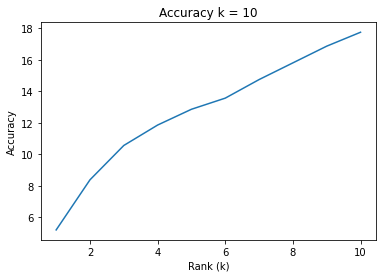

In [ ]:
import matplotlib.pyplot as plt

# initialize laoders
_, test_set, icons_Test, sketches_Test = make_train_test_sets()
print("The size of test icons is: " + str(len(icons_Test)))
print("The size of test sketches is: " + str(len(sketches_Test)))
test_loader = build_loaders(test_set, mode="test")
icons_path_list = []
for name, category in icons_Test:
  icons_path_list.append(category + "/" + name + ".jpg")
icons_loader = build_icon_test_loader(icons_path_list, mode="test")

main_folder_path = "/content/gdrive/MyDrive/Results-Cluster/ResNet50/CLIP-Sketch-Icon-Quickdraw-Pretrained/23-05-2021 16-16-22/"
# main_folder_path = "/content/gdrive/MyDrive/Results-Cluster/ResNet50/CLIP-Sketch-Icon-Human-Pretrained/24-05-2021 12-50-25/"
model_path = main_folder_path + "Train Weights/"
model = CLIPModel().to(CFG.device)
model.load_state_dict(torch.load(model_path + "ClipModel.pt", map_location=CFG.device))
model.eval()


sketch_embeddings, icon_embeddings = get_sketch_and_icon_features(test_loader, icons_loader, model)
acc_1 = 0
acc_10 = 0
top_k_list = [0] * 10
for sketch_features, name in zip(sketch_embeddings, test_set["sketches"]):
  name = name.split("/")[1]
  # Pick the top 10 most similar labels for the image
  sketch_features = sketch_features.unsqueeze(0)
  sketch_features /= sketch_features.norm(dim=-1, keepdim=True)
  icon_embeddings /= icon_embeddings.norm(dim=-1, keepdim=True)

  similarity = (100.0 * sketch_features @ icon_embeddings.T).softmax(dim=-1)
  values, indices = similarity[0].topk(10)
  top_10 = 0
  count = 0
  for index in indices:
    if icons_Test[index][0] == name.split("_")[0] and count == 0:
      top_k_list[count] = top_k_list[count] + 1
      acc_1 = acc_1 + 1
      acc_10 = acc_10 + 1
      break
    elif icons_Test[index][0] == name.split("_")[0]:
      top_k_list[count] = top_k_list[count] + 1
      acc_10 = acc_10 + 1
      break
    count = count + 1

print("Top 1: " + str(acc_1/len(sketches_Test)))
print("Top 10: " + str(acc_10/len(sketches_Test)))

axisX = [0] * 10
for i in range(0 , len(axisX)):
  axisX[i] = i + 1

for i in range(1, len(top_k_list)):
  top_k_list[i] = top_k_list[i] + top_k_list[i-1]
  top_k_list[i-1] = top_k_list[i-1] / len(sketches_Test) * 100
top_k_list[9] = top_k_list[9] / len(sketches_Test) * 100

plt.plot(axisX,top_k_list)
# plt.ylim(ymin=0)
# plt.xlim(xmin=0)
plt.title('Accuracy k = 10')
plt.xlabel('Rank (k)')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
rank_file = open(main_folder_path + "top_10.txt","w+")
top_10_list_string = ['{:.2f}'.format(x) for x in top_k_list]
for value in top_10_list_string:
  rank_file.write(value + "\n")
rank_file.close()

In [ ]:
icon_embeddings_numpy = icon_embeddings.cpu().detach().numpy()
print(icon_embeddings_numpy)
np.save("icon_features.npy", icon_embeddings_numpy,  allow_pickle=True)

[[ 0.02888797  0.0393635   0.01229858 ...  0.01171753 -0.00476455
  -0.01394455]
 [ 0.02104254  0.05825183  0.04472658 ...  0.0403649   0.04904578
   0.07103293]
 [ 0.01274345  0.02099517 -0.03103044 ...  0.03863605 -0.00489595
   0.00978747]
 ...
 [ 0.0147633   0.01220762  0.0319633  ...  0.03497045  0.01758769
  -0.01016995]
 [ 0.05634179  0.02654875 -0.01178873 ... -0.00853087  0.04050625
   0.00554829]
 [ 0.01545266 -0.00944267  0.00574177 ... -0.03730685 -0.00732866
   0.00751743]]


In [ ]:
_, test_set, icons_Test, sketches_Test = make_train_test_sets()
icons_Test_Temp = icons_Test
for i in range(0, len(icons_Test_Temp)):
  icons_Test_Temp[i][0] = icons_Test_Temp[i][0] + ".jpg"

print(icons_Test_Temp)
np.save("icon_info_clip.npy", icons_Test_Temp,  allow_pickle=True)

[['campground.jpg' 'camping']
 ['vihara.jpg' 'buildings']
 ['shopping-cart.jpg' 'shopping']
 ...
 ['arrow-left.jpg' 'arrows']
 ['file-invoice-dollar.jpg' 'finance']
 ['flushed.jpg' 'emoji']]


In [16]:
import matplotlib.pyplot as plt

# initialize laoders
_, test_set, icons_Test, sketches_Test = make_train_test_sets()
print("The size of test icons is: " + str(len(icons_Test)))
print("The size of test sketches is: " + str(len(sketches_Test)))
test_loader = build_loaders(test_set, mode="test")
icons_path_list = []
for name, category in icons_Test:
  icons_path_list.append(category + "/" + name + ".jpg")
icons_loader = build_icon_test_loader(icons_path_list, mode="test")

# model_path = "/content/gdrive/MyDrive/Thesis/ResNet50/CLIP-Sketch-Icon-SyntheticData-Pretrained/22-05-2021 18-13-55/Train Weights/"
model_path = "/content/gdrive/MyDrive/Results-Cluster/ResNet50/CLIP-Sketch-Icon-Human-Pretrained/24-05-2021 12-50-25/Train Weights/"
model = CLIPModel().to(CFG.device)
model.load_state_dict(torch.load(model_path + "ClipModel.pt", map_location=CFG.device))
model.eval()


sketch_embeddings, icon_embeddings = get_sketch_and_icon_features(test_loader, icons_loader, model)
acc_1 = 0
acc_10 = 0
for sketch_features, name in zip(sketch_embeddings, test_set["sketches"]):
  sketch_name = name
  name = name.split("/")[1]
  # Pick the top 10 most similar labels for the image
  sketch_features = sketch_features.unsqueeze(0)
  sketch_features /= sketch_features.norm(dim=-1, keepdim=True)
  icon_embeddings /= icon_embeddings.norm(dim=-1, keepdim=True)

  img = cv2.imread(f"{CFG.sketch_path}/{sketch_name}")
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

  similarity = (100.0 * sketch_features @ icon_embeddings.T).softmax(dim=-1)
  values, indices = similarity[0].topk(10)
  top_10 = 0
  count = 0
  fig = plt.figure(figsize=[20,20])
  for index in indices:
    if icons_Test[index][0] == name.split("_")[0] and count == 0:
      acc_1 = acc_1 + 1
      acc_10 = acc_10 + 1
      print("hit")
    elif icons_Test[index][0] == name.split("_")[0]:
      acc_10 = acc_10 + 1
      print("hit")
    count = count + 1

    img = cv2.imread(CFG.icon_path + "/" + icons_Test[index][1] + "/" + icons_Test[index][0] + ".jpg")
    plt.subplot(1, 10, count)
    plt.imshow(img)
    plt.axis('off')
  plt.show()    

print("Top 1: " + str(acc_1/len(sketches_Test)))
print("Top 10: " + str(acc_10/len(sketches_Test)))

Output hidden; open in https://colab.research.google.com to view.

![](./images/dance.png)

## Final words

I hope you have enjoyed this article. Implementing this paper was a really interesting experience for me. I want to thank Khalid Salama for the great Keras code example he provided which inspired me to write something similar in PyTorch.